In [ ]:
%%capture --no-stderr
%pip install --quiet -U langchain langchain_openai tavily-python langgraph langchain_groq langchain_cohere

In [ ]:
from google.colab import userdata
import os

os.environ['COHERE_API_KEY'] = userdata.get('COHERE_KEY')
os.environ['GROQ_API_KEY'] = userdata.get('GROQ_API_KEY')
os.environ['TAVILY_API_KEY'] = userdata.get('TAVILY_KEY')

In [ ]:
!pip install -Uq langchain_community langchainhub langchain-google-genai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.3/49.3 kB 6.5 MB/s eta 0:00:00


In [ ]:
from langchain_community.tools.tavily_search import TavilySearchResults

tools = [TavilySearchResults(max_results=3)]

In [ ]:
from langchain_groq import ChatGroq

llm = ChatGroq(temperature=0)

In [ ]:
from langchain_core.pydantic_v1 import BaseModel, Field
from typing import List

class Response(BaseModel):
  """Response from the model, list containing the symbols"""
  symbols: List[str] = Field(
      description="list of Stock symbols from output query"
  )

In [ ]:
model = llm.bind_tools(tools + [Response])

In [ ]:
from typing import TypedDict, Annotated, Sequence
import operator
from langchain_core.messages import BaseMessage


class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]
    sender: str
    symbols: List[Sequence[BaseMessage]]

In [ ]:
finnhub_token = userdata.get('X-FINNHUB-TOKEN')
av_key = userdata.get('AV_KEY')

In [ ]:
!pip -q install finnhub-python

In [ ]:
from langchain_core.tools import tool
from langchain.pydantic_v1 import BaseModel, Field
import requests
import csv

In [ ]:
@tool('get_expected_earnings')
def get_expected_earnings(symbol: str):
  """use to get the expected earnings of a company, takes in company symbol and no. of months as input, output contain document with earnings"""
  CSV_URL = f'https://www.alphavantage.co/query?function=EARNINGS_CALENDAR&symbol={symbol}&horizon=3month&apikey={av_key}'

  document = ''
  with requests.Session() as s:
      download = s.get(CSV_URL)
      decoded_content = download.content.decode('utf-8')
      cr = csv.reader(decoded_content.splitlines(), delimiter=',')
      for row in cr:
        document += ','.join(row) + '\n'

  return document

In [ ]:
import finnhub
from datetime import date, timedelta
import json

@tool('get_insider_sentiment')
def insider_sentiment(symbol: str):
  """
  Get json containing the insider sentiment towards the particular company for 3 months time from current date
  input: Stock symbol
  output: json containing the insider sentiments for 3 month time
  """
  today = date.today()
  start = today - timedelta(days=3 * 30)
  finnhub_client = finnhub.Client(api_key=finnhub_token)

  sentiment = finnhub_client.stock_insider_sentiment(symbol, start, today)

  return json.dumps(sentiment)

In [ ]:
@tool('get_insider_transactions')
def insider_transactions(symbol: str):
  """
  Get json containing the insider tranasaction towards the particular company stock for 2 months time from current date
  input: Stock symbol
  output: json containing the insider transactions for 3 month time
  """
  today = date.today()
  start = today - timedelta(days=2 * 30)
  finnhub_client = finnhub.Client(api_key=finnhub_token)

  transactions = finnhub_client.stock_insider_transactions(symbol,  start, today)

  return json.dumps(transactions)

In [ ]:
from datetime import datetime

@tool('get_outsider_sentiment')
def get_news_sentiment(symbol: str):
  """
  get outsider sentiment
  get news with sentiment score about company with stock symbol passed as input. \n
  news will be used for sentiment analysis for finance & stock trade decisions
  output: json containing the metadata and news
  """
  now = datetime.now() - timedelta(days=30)
  formatted_time = now.strftime("%Y%m%dT%H%M")
  url = f'https://www.alphavantage.co/query?function=NEWS_SENTIMENT&tickers={symbol}&apikey={av_key}'
  r = requests.get(url)
  data = r.json()

  return json.dumps(data)

In [ ]:
from langchain_core.messages import (
    BaseMessage,
    ToolMessage,
    HumanMessage,
)
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langgraph.graph import END, StateGraph


def create_agent(llm, tools, system_message: str):
    """Create an agent."""
    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                "You are a helpful AI Stock bocker Assistant, collaborating with other assistants."
                " Use the provided tools to progress towards answering the question."
                " If you are unable to fully answer, that's OK, another assistant with different tools "
                " will help where you left off. Execute what you can to make progress."
                " If you or any of the other assistants have the final answer or deliverable,"
                "For some tools you need to use the stock symbol to get proper response. use all tools before FINAL ANSWER"
                " prefix your response with FINAL ANSWER so the team knows to stop."
                " You have access to the following tools: {tool_names}.\n{system_message}",
            ),
            MessagesPlaceholder(variable_name="messages"),
            MessagesPlaceholder(variable_name="symbols"),
        ]
    )
    prompt = prompt.partial(system_message=system_message)
    prompt = prompt.partial(tool_names=", ".join([tool.name for tool in tools]))
    return prompt | llm.bind_tools(tools)

In [ ]:
import functools
from langchain_core.messages import (
    BaseMessage,
    ToolMessage,
    HumanMessage,
    AIMessage
)

def agent_node(state, agent, name):
  result = agent.invoke(state)
  print(result)
  if isinstance(result, ToolMessage):
    pass
  else:
    result = AIMessage(**result.dict(exclude={'type', 'name'}), name=name)

  return {
      "messages": [result],
      "symbols": state["symbols"],
      "sender": name
  }

In [ ]:
os.environ['GOOGLE_API_KEY'] = userdata.get('GEMINI_API_KEY')

In [ ]:
from langchain_google_genai import ChatGoogleGenerativeAI

llm = ChatGoogleGenerativeAI(model='gemini-1.5-flash-latest')

In [ ]:
llm.Config

langchain_google_genai.chat_models.ChatGoogleGenerativeAI.Config

In [ ]:
sentiment_agent = create_agent(
    llm,
    [insider_sentiment, insider_transactions],
    system_message="You should use the stock symbol to make api calls to get insider trade infomation"
)

insider_node = functools.partial(agent_node, agent=sentiment_agent, name='sentiment')

In [ ]:
growth_agent = create_agent(
    llm,
    [get_expected_earnings],
    system_message="Use stock symbol to complete api call to get expected earnings over a set period of time"
)

growth_node = functools.partial(agent_node, agent=growth_agent, name='Growth')

news_agent = create_agent(
    llm,
    [get_news_sentiment],
    system_message="Use stock symbol to make api call to get related news with sentiment score."
)

news_node = functools.partial(agent_node, agent=news_agent, name='News')

In [ ]:
research_agent = create_agent(
    llm,
    tools,
    system_message="Research and create final answer from other tools and sources"
)

research_node = functools.partial(agent_node, agent=research_agent, name='Researcher')

In [ ]:
from langgraph.prebuilt import ToolNode

tools = tools + [insider_sentiment, insider_transactions, get_expected_earnings, get_news_sentiment]
tool_node = ToolNode(tools)

In [ ]:
# Either agent can decide to end
from typing import Literal


def router(state) -> Literal["call_tool", "__end__", "continue"]:
    # This is the router
    messages = state["messages"]
    last_message = messages[-1]
    if last_message.tool_calls:
        # The previous agent is invoking a tool
        return "call_tool"
    if "FINAL ANSWER" in last_message.content:
        # Any agent decided the work is done
        return "__end__"
    return "continue"

In [ ]:
workflow = StateGraph(AgentState)

workflow.add_node("Researcher", research_node)
workflow.add_node("Insider", insider_node)
workflow.add_node("Growth", growth_node)
workflow.add_node("News", news_node)

workflow.add_node("call_tool", tool_node)


workflow.add_conditional_edges(
    "Researcher",
    router,
    {"continue": "News", "call_tool": "call_tool", "__end__": END},
)

workflow.add_conditional_edges(
    "Insider",
    router,
    {"continue": "Researcher", "call_tool": "call_tool", "__end__": END},
)

workflow.add_conditional_edges(
    "Growth",
    router,
    {"continue": "Insider", "call_tool": "call_tool", "__end__": END},
)

workflow.add_conditional_edges(
    "News",
    router,
    {"continue": "Growth", "call_tool": "call_tool", "__end__": END},
)

workflow.add_conditional_edges(
    "call_tool",
    # Each agent node updates the 'sender' field
    # the tool calling node does not, meaning
    # this edge will route back to the original agent
    # who invoked the tool
    lambda x: x["sender"],
    {
        "Researcher": "Researcher",
        "Insider": "Insider",
        "Growth": "Growth",
        "News" : "News"
    },
)
workflow.set_entry_point("News")
graph = workflow.compile()

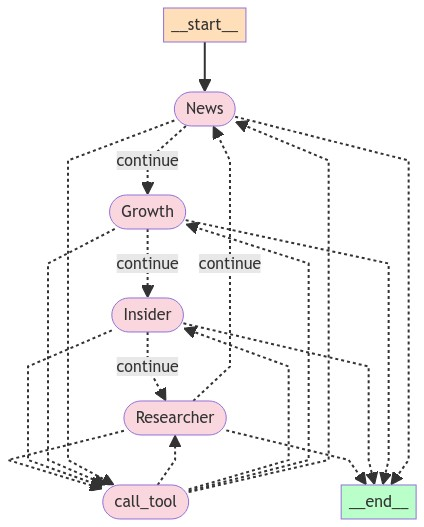

In [ ]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except:
    # This requires some extra dependencies and is optional
    pass

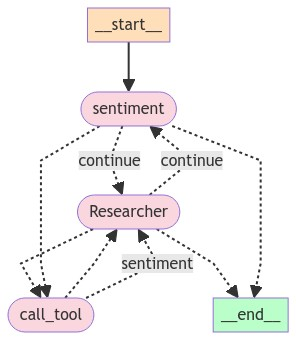

In [ ]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except:
    # This requires some extra dependencies and is optional
    pass

In [ ]:
from langchain_core.messages import HumanMessage

inputs = {
    "messages": [HumanMessage(content="What is the public sentiment of tesla stock?")],
    "symbols": ["TSLA"]
    }

In [ ]:
gr = graph.invoke(inputs)

content='' additional_kwargs={'function_call': {'name': 'get_outsider_sentiment', 'arguments': '{"symbol": "TSLA"}'}} response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': [{'category': 'HARM_CATEGORY_DANGEROUS_CONTENT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_HARASSMENT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_HATE_SPEECH', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_SEXUALLY_EXPLICIT', 'probability': 'NEGLIGIBLE', 'blocked': False}]} id='run-3b446b9d-2d87-493b-ab68-f6f6bdb079de-0' tool_calls=[{'name': 'get_outsider_sentiment', 'args': {'symbol': 'TSLA'}, 'id': '6eec039c-c41e-4329-898e-ff3b3bcf13b1'}]
content="The public sentiment towards Tesla stock is currently mixed.  Some recent news articles suggest a neutral sentiment, while others are somewhat bullish or bearish. \n\nFor example, one article about Tesla's 

KeyboardInterrupt: 